### Read data and import necessary libraries and functions

In [150]:
# Import necessary functionality
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, udf, cos, radians, sin, sqrt, atan2, year, concat, substring, lit, avg, regexp_extract, expr, min, max, sum, count
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

# Create a SparkSession
spark = SparkSession.builder.appName("WindEnergy").getOrCreate()

# Read wind core sites data and select relevant columns and convert column namees to english
sites_df = spark.read.option("sep", ";").csv("data/metobs_wind_core_sites.csv", header=True, inferSchema=True).select(
    col("Id"),
    col("Namn").alias("Name"),
    col("Latitud"),
    col("Longitud"),
    col("Aktiv").alias("Active")
)

# Read wind turbine data
turbine_df = spark.read.option("sep", ",").csv("data/VBK_export_allman_prod - Vindkraftverk.csv", header=True, inferSchema=True).select(
    col("Verk-ID").alias("Turbine-ID"),
    col("Status"),
    col("Placering").alias("Placement"),
    col("N-Koordinat").alias("N-Coordinate"),
    col("E-Koordinat").alias("E-Coordinate"),
    col("Maxeffekt (MW)").alias("Maxeffect (MW)"),
    col("Elområde").alias("Bidding_Zone"),
    col("Uppfört").alias("Built")
)

sites_df.show(n=5)
turbine_df.show(n=5)


+------+---------------+-------+--------+------+
|    Id|           Name|Latitud|Longitud|Active|
+------+---------------+-------+--------+------+
|154860|Abelvattnet Aut|  65.53|   14.97|   Nej|
|188790|     Abisko Aut|68.3538| 18.8164|    Ja|
|158990|         Abraur|65.9857| 18.9195|   Nej|
| 97280|       Adelsö A|59.3579| 17.5213|    Ja|
|117330|            Agö|  61.55| 17.4666|   Nej|
+------+---------------+-------+--------+------+
only showing top 5 rows

+--------------+-----------+----------+------------+------------+--------------+--------------------+----------+
|    Turbine-ID|     Status| Placement|N-Coordinate|E-Coordinate|Maxeffect (MW)|        Bidding_Zone|     Built|
+--------------+-----------+----------+------------+------------+--------------+--------------------+----------+
|0117-V-004-001|    Uppfört|Land      |   6608791.7|    704443.5|          0.09|Stockholm           |2009-12-23|
|0136-V-001-001|Nedmonterat|      Land|  6539904.29|   686876.11|          0.22|St

### Data cleaning

In [151]:
turbine_df.select("Placement").distinct().show()
turbine_df.select("Bidding_Zone").distinct().show()

# Strip column values
turbine_df = turbine_df.withColumn("Bidding_Zone", regexp_replace(col("Bidding_Zone"), "\\s+", ""))
turbine_df = turbine_df.withColumn("Placement", regexp_replace(col("Placement"), "\\s+", ""))

turbine_df.select("Placement").distinct().show()
turbine_df.select("Bidding_Zone").distinct().show()

+----------+
| Placement|
+----------+
|Vatten    |
|      Land|
|Land      |
|    Vatten|
|      NULL|
+----------+

+--------------------+
|        Bidding_Zone|
+--------------------+
|Stockholm           |
|Sundsvall           |
|Luleå               |
|Malmö               |
+--------------------+

+---------+
|Placement|
+---------+
|     Land|
|   Vatten|
|     NULL|
+---------+

+------------+
|Bidding_Zone|
+------------+
|   Stockholm|
|       Luleå|
|   Sundsvall|
|       Malmö|
+------------+



### Filter DataFrames

In [152]:
# Filter out turbines:
#    not on land, 
#    not in production and 
#    not in Bidding Zone 1 (Luleå)
#    turbines with less than 1.01 max effect
turbine_df = turbine_df.filter((col("Status") == "Uppfört") & (col("Placement") == "Land") & (col("Bidding_Zone") == "Luleå") & (col("Maxeffekt (MW)")<1.01))

# Filter out non-active wind core sites
sites_df = sites_df.filter((col("Active") == "Ja"))

### Define helper functions

In [153]:
# Function for transformation sweref99 tm to longitude and latitude coordinates
def sweref99_to_latlon(E, N):
    # Constants for SWEREF99 TM projection
    E0 = 500000  # False Easting in meters
    N0 = 0       # False Northing in meters
    F0 = 0.9996  # Scale factor at central meridian
    lo0 = math.radians(15)  # Central meridian in radians
    a = 6378137.0  # Semi-major axis of WGS 84 ellipsoid in meters
    la0 = 0  # Latitude of projection origin in radians

    # Convert
    lat = la0 + (N - N0) / (a * F0)
    long = lo0 + (E - E0) / (a * F0 * cos(lat))

    return lat, long

# Calculate distance between points (E, N) and (lat, long)
def distance(E, N, lat, long):

    # Convert E-kooridnat and N-kooridnat to (lat1, lon1)
    lat1, lon1 = sweref99_to_latlon(E, N)
    
    # Convert to radians
    lat2 = radians(lat)
    lon2 = radians(long)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    # Radius of the Earth in kilometers (mean value)
    radius_earth = 6371.0
    
    # Calculate the distance
    distance = radius_earth * c
    
    return distance

distance_udf = udf(distance, FloatType())

### Map turbine to closest wind core site

In [156]:
mapping_df = turbine_df.crossJoin(sites_df)

# Calculate distance between each turbine and wind core site
mapping_df = mapping_df.withColumn("distance(km)", distance(mapping_df["E-Coordinate"], mapping_df["N-Coordinate"], mapping_df["Latitud"], mapping_df["Longitud"]))

# Find the distance to the closes wind core site for each turbine
min_distance_df = mapping_df.groupBy("Turbine-ID").agg(min(col("distance(km)")).alias("distance(km)"))

# Map each wind turbine to the closest wind core site
mapping_df = mapping_df.join(min_distance_df, ["Turbine-ID", "distance(km)"], "inner").select("Turbine-ID", "distance(km)", "Maxeffect (MW)", "Built", "Id", "Name")
print("Number of turbines", mapping_df.count())
mapping_df.show()

Number of turbines 21
+--------------+------------------+--------------+----------+------+--------------------+
|    Turbine-ID|      distance(km)|Maxeffect (MW)|     Built|    Id|                Name|
+--------------+------------------+--------------+----------+------+--------------------+
|2580-V-002-001| 16.62211951817588|          0.02|2007-10-22|162860|Luleå-Kallax Flyg...|
|2418-V-012-001|  18.8234827456979|           0.8|2009-01-01|149560|            Norsjö A|
|2514-V-001-002|1.0310616379964619|          0.85|2009-01-01|163900|            Storön A|
|2514-V-001-001|0.8824780796831564|          0.85|2009-01-01|163900|            Storön A|
|2584-V-004-001|13.852286626564473|           0.9|2001-09-18|180940|    Kiruna Flygplats|
|2583-V-001-003|19.613478002660717|           1.0|2006-04-05|163960|         Haparanda A|
|2583-V-001-005|18.730632310986348|           1.0|2006-04-05|163960|         Haparanda A|
|2584-V-007-001|13.336059293615653|           0.9|2001-09-01|180940|    Kiruna

### Read wind speed data

In [164]:
# List to store individual DataFrames
dataframes = []

# Loop through all files in the folder
for filename in os.listdir("data/weather_data_mean/"):
    if filename.endswith('.csv'):  # Assuming your files have a .csv extension
        file_path = os.path.join("data/weather_data_mean/", filename)

        # Extract id from filename
        parts = filename.split('_')
        id = parts[3]

        temp_df = spark.read.option("sep", ";").csv(file_path, header=True, inferSchema=True)

        # Select necessary fields and format date and time
        temp_df = temp_df.filter(year('Datum') >= 2020)
        temp_df = temp_df.withColumn('timestamp', concat(col('Datum'), substring(col('Tid (UTC)').cast('string'), 11, 100)))
        temp_df = temp_df.select(col("Vindhastighet").alias("wind_speed"), col("timestamp"))
        temp_df = temp_df.withColumn('Id', lit(id))
        
        dataframes.append(temp_df)

# Concatenate the DataFrames
wind_df = dataframes[0]  # Initialize with the first DataFrame
for df in dataframes[1:]:
    wind_df = wind_df.union(df)

wind_df.show(n=5)

+----------+-------------------+------+
|wind_speed|          timestamp|    Id|
+----------+-------------------+------+
|       0.0|2020-01-01 00:00:00|149340|
|       0.0|2020-01-01 01:00:00|149340|
|       0.8|2020-01-01 02:00:00|149340|
|       0.7|2020-01-01 03:00:00|149340|
|       1.1|2020-01-01 04:00:00|149340|
+----------+-------------------+------+
only showing top 5 rows



### Merge wind speed data with wind turbine mapping data

In [159]:
# Join wind measurement data and wind turbine data
data_df = mapping_df.join(wind_df, "Id", "inner")

# For each timestamp filter out windturbines that were built on a later date
data_df = data_df.filter(col("timestamp")>col("Built"))

# Group by wind core site and timestamp counting the number of turbines mapped to it
# (wind_speed will be the same for each row)
data_df = data_df.groupBy("Id", "timestamp").agg(
    count("*").alias("Turbines"),
    min("wind_speed").alias("wind_speed"),
)

# Group by timestamp calculating average windspeed across wind core sites
# weighted by the number of turbines mapped to each wind core site
data_df = data_df.groupBy("timestamp").agg(
     (sum(expr("wind_speed * Turbines")) / sum("Turbines")).alias("weighted_avg_wind_speed")
)

data_df.show()

+-------------------+-----------------------+
|          timestamp|weighted_avg_wind_speed|
+-------------------+-----------------------+
|2020-01-16 08:00:00|      1.723809523809524|
|2020-01-19 21:00:00|      2.638095238095238|
|2020-01-24 00:00:00|     4.6380952380952385|
|2020-01-26 15:00:00|     2.6142857142857143|
|2020-01-27 03:00:00|     2.2142857142857144|
|2020-01-28 10:00:00|     3.6380952380952385|
|2020-02-22 09:00:00|      6.880952380952381|
|2020-02-26 02:00:00|     2.4476190476190474|
|2020-03-05 10:00:00|      3.685714285714286|
|2020-03-12 02:00:00|     1.8476190476190475|
|2020-03-15 22:00:00|                  4.195|
|2020-03-25 20:00:00|                   6.65|
|2020-04-07 06:00:00|     3.1476190476190475|
|2020-04-10 10:00:00|      4.228571428571429|
|2020-04-16 13:00:00|      4.266666666666667|
|2020-04-17 20:00:00|      6.780952380952381|
|2020-04-17 22:00:00|      6.485714285714285|
|2020-04-25 21:00:00|      4.057142857142857|
|2020-04-27 14:00:00|     2.900000

In [165]:
def rollingAverage3h(file_path):
    df = spark.read.csv(file_path, header=True, inferSchema=True).select("MTU", "Wind Onshore  - Actual Aggregated [MW]")
    
    # just display the end time of the time frame
    df_with_time = df.withColumn("End_Time", regexp_extract(df["MTU"], r"(\d{2}\.\d{2}\.\d{4} \d{2}:\d{2} \(UTC\))", 1))
    
    # 3h sliding window average to adhere to wind measurements
    windowSpec = Window.orderBy("End_Time").rowsBetween(-2, 0)

    df_with_avg = df_with_time.withColumn("Rolling Average 3h in MWh", avg("Wind Onshore  - Actual Aggregated [MW]").over(windowSpec))

    # Select relevant fields
    df_clean = df_with_avg.select(
        col("End_Time"), 
        col("Rolling Average 3h in MWh")
    )
    
    return df_clean

df_average2021 = rollingAverage3h("data/production/SE1Onshore2021UTC.csv")

df_average2022 = rollingAverage3h("data/production/SE1Onshore2022UTC.csv")

# Join years into a single dataframe
df_both_years = df_average2021.union(df_average2022)

# format data and time to adhere to wind measurements fromatting
df_both_years = df_both_years.withColumn("timestamp",
                   expr("concat(substring(End_Time, 7, 4),'-' ,substring(End_Time, 4, 2),'-', substring(End_Time, 1, 2), ' ', substring(End_Time, 12, 5), ':00')")).select("Rolling Average 3h in MWh", "timestamp")

df_both_years.show(truncate=False)

+-------------------------+-------------------+
|Rolling Average 3h in MWh|timestamp          |
+-------------------------+-------------------+
|116.0                    |2021-01-01 01:00:00|
|113.0                    |2021-01-01 02:00:00|
|112.66666666666667       |2021-01-01 03:00:00|
|118.66666666666667       |2021-01-01 04:00:00|
|136.66666666666666       |2021-01-01 05:00:00|
|164.66666666666666       |2021-01-01 06:00:00|
|173.33333333333334       |2021-01-01 07:00:00|
|174.66666666666666       |2021-01-01 08:00:00|
|167.33333333333334       |2021-01-01 09:00:00|
|166.66666666666666       |2021-01-01 10:00:00|
|167.33333333333334       |2021-01-01 11:00:00|
|161.66666666666666       |2021-01-01 12:00:00|
|151.0                    |2021-01-01 13:00:00|
|135.0                    |2021-01-01 14:00:00|
|122.66666666666667       |2021-01-01 15:00:00|
|120.66666666666667       |2021-01-01 16:00:00|
|127.0                    |2021-01-01 17:00:00|
|133.33333333333334       |2021-01-01 18

In [166]:
data_df = df_both_years.join(other=data_df, how="inner", on="timestamp")
data_df.show()

+-------------------+-------------------------+-----------------------+
|          timestamp|Rolling Average 3h in MWh|weighted_avg_wind_speed|
+-------------------+-------------------------+-----------------------+
|2021-01-02 13:00:00|       55.666666666666664|      2.280952380952381|
|2021-01-22 15:00:00|        916.6666666666666|      6.742857142857143|
|2021-01-23 19:00:00|        655.3333333333334|     3.7523809523809524|
|2021-01-28 17:00:00|                    226.0|     2.1523809523809527|
|2021-01-29 17:00:00|       128.33333333333334|     2.5285714285714285|
|2021-02-12 03:00:00|       1016.3333333333334|      4.033333333333333|
|2021-02-13 20:00:00|                    621.0|     2.9142857142857146|
|2021-02-14 21:00:00|        536.6666666666666|     3.1809523809523808|
|2021-02-15 19:00:00|        502.3333333333333|       3.08095238095238|
|2021-02-16 15:00:00|       24.333333333333332|     2.1285714285714286|
|2021-02-20 20:00:00|                    204.0|      4.319047619

### Perform Analysis

In [167]:

correlation = data_df.corr("weighted_avg_wind_speed", "Rolling Average 3h in MWh", method="pearson")

print(f"Linear Correlation between wind and energy: {correlation}")


Linear Correlation between wind and energy: 0.6790435768535638


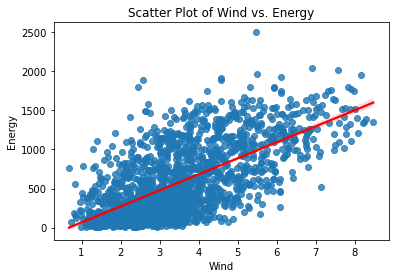

In [168]:

sample_df = data_df.select("weighted_avg_wind_speed", "Rolling Average 3h in MWh").sample(False, 0.1, seed=1)
# Convert the DataFrame to Pandas for plotting
pandas_df = sample_df.select("weighted_avg_wind_speed", "Rolling Average 3h in MWh").toPandas()

# Create a scatter plot
sns.regplot(x=pandas_df['weighted_avg_wind_speed'], y=pandas_df['Rolling Average 3h in MWh'], line_kws={"color": "red"})
plt.xlabel('Wind')
plt.ylabel('Energy')
plt.title('Scatter Plot of Wind vs. Energy')
plt.show()